In [1]:
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
import geopandas
# from utilities.weatherFunctions import *
# from utilities.geographicFunctions import *

In [19]:
import bokeh
from bokeh.layouts import *
from bokeh.models import *
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span

In [3]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [28]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(heatwaves,title, source, markers=False, subtitle=None, measure = 'heat_index', category = 'city'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, city in enumerate(heatwaves['city'].unique()):
        df = heatwaves[heatwaves[category]==city].groupby('time').mean().reset_index()[['time', measure]]
        p2.line(df['time'], df[measure], line_width=2, line_color = color_palette[id], legend_label=city)

    # p2.legend.click_policy='hide'
    # if subtitle is not None:
    #     p2.title = subtitle

    p2.title = title
    # title_fig = figure(title=title, toolbar_location=None,width=1000, height=40, )
    # title_fig.title.align = "left"
    # title_fig.title.text_font_size = "20pt"
    # title_fig.border_fill_alpha = 0
    # title_fig.outline_line_width=0

    # #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=1000, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(p2, sub_title)

#     if markers:
#         p2.renderers.extend([
#         Span(
#             location=datetime(2020, 3, 15),
#             dimension="height",
#             line_color='#7C7C7C',
#             line_width=2,
#             line_dash=(4,4)
#       ),
#         Span(
#             location=datetime(2021, 2, 15),
#             dimension="height",
#             line_color='#7C7C7C',
#             line_width=2,
#             line_dash=(4,4)
#         ),
#     ]
# )

    return layout

In [5]:
def clip_area(ds, area):

    ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped_area = ds.rio.clip(area.geometry.values,all_touched=True, drop=True)

    return clipped_area

# Measuring heatwaves in the Philippines

In [6]:
ds_mean2_gldas=xr.open_mfdataset("../../data/gldas/ymean2/wld_cli_*.nc4", parallel = True)

Read the shapefiles for Philippines

In [7]:
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm2_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'])]
PHILIPPINES_ADM3 = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp')
DAVAO = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Davao City'])]
ZAMBOANGA = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Zamboanga City'])]
CEBU = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Cebu City'])]

Read population data for the Philippines

In [150]:
import dask.dataframe as dd
import dask_geopandas as dg
population = pd.read_csv('../../data/population/phl_general_2020.csv')
#population_dg = dg.from_dask_dataframe(population)

In [153]:
import geopandas as gpd
geometry = gpd.points_from_xy(population['longitude'], population['latitude'])
population_gdf = geopandas.GeoDataFrame(population, geometry=geometry)

In [156]:
population_adm3 = PHILIPPINES_ADM3.sjoin(population_gdf)


c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [170]:
population_adm3 = population_adm3[['ADM3_EN', 'phl_general_2020']].groupby(['ADM3_EN']).sum().reset_index()
population_adm2 = population_adm2[['ADM2_EN', 'phl_general_2020']].groupby(['ADM2_EN']).sum().reset_index()

In [161]:
PHILIPPINES_ADM3 = PHILIPPINES_ADM3.merge(population_adm3, on = 'ADM3_EN')

In [171]:
PHILIPPINES_ADM2 = PHILIPPINES.merge(population_adm2, on = 'ADM2_EN')

In [214]:
#PHILIPPINES_ADM3

[]

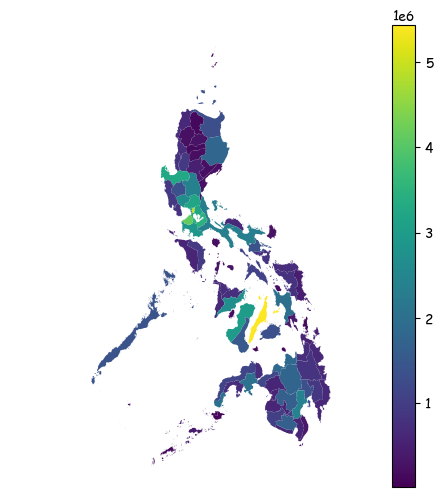

In [178]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))
plt.rcParams["font.family"] = "cursive"

PHILIPPINES_ADM2.plot(column='phl_general_2020', legend = True, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

In [185]:
PHILIPPINES_ADM2.to_file('../../data/population/phl_adm2.geojson')

In [8]:
def add_city_name(df, city_name):
    df['city'] = city_name

    return df

## Comparing HWDI, Heat Index from NASA GLDAS along with PASAY PHL Govt Heat Index Data

In [9]:
manila_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, MANILA).to_dataframe().reset_index(), 'Manila')
davao_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, DAVAO).to_dataframe().reset_index(), 'Davao')
zamboanga_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, ZAMBOANGA).to_dataframe().reset_index(), 'Zamboanga')
cebu_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, CEBU).to_dataframe().reset_index(), 'Cebu')

In [10]:
manila_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/manila_heat_index_daily.csv'), 'Manila')
davao_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/davao_heat_index_daily.csv'), 'Davao')
zamboanga_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/zamboanga_heat_index_daily.csv'), 'Zamboanga')
cebu_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/cebu_heat_index_daily.csv'), 'Cebu')

In [219]:
manilaport_heatindex_pasay = add_city_name(gpd.read_file('../../data/pasay/pag_port.geojson'), 'Manila Port')
manilaquezon_heatindex_pasay = add_city_name(gpd.read_file('../../data/pasay/pag_quezon.geojson'), 'Quezon')
manilapasay_heatindex_pasay = add_city_name(gpd.read_file('../../data/pasay/pag_pasay.geojson'), 'Pasay')

In [338]:
manilaport_heatindex_max = add_city_name(gpd.read_file('../../data/pasay/pag_port_max.geojson'), 'Manila Port')
manilaquezon_heatindex_max = add_city_name(gpd.read_file('../../data/pasay/pag_quezon_max.geojson'), 'Quezon')
manilapasay_heatindex_max = add_city_name(gpd.read_file('../../data/pasay/pag_pasay_max.geojson'), 'Pasay')

In [221]:
phl_cities_heatindex_pasay = pd.concat([manilaport_heatindex_pasay, manilaquezon_heatindex_pasay, manilapasay_heatindex_pasay])

In [340]:
from datetime import datetime
manilaport_heatindex_max['Date'] = manilaport_heatindex_max['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
#manilaquezon_heatindex_max['Date'] = manilaquezon_heatindex_max['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%y'))

In [341]:
phl_cities_heatindex_pasay_max = pd.concat([manilaport_heatindex_max, manilaquezon_heatindex_max, manilapasay_heatindex_max])

In [339]:
manilaquezon_heatindex_max['Date'] = pd.to_datetime(manilaquezon_heatindex_max[['Year', 'Month', 'Day']])

In [342]:
phl_cities_heatindex_pasay_max.rename(columns = {'Date':'time'}, inplace=True)

In [11]:
phl_cities_hwdi_mean2 = pd.concat([manila_hwdi_mean2, zamboanga_hwdi_mean2, davao_hwdi_mean2, cebu_hwdi_mean2])
phl_cities_heatindex = pd.concat([manila_heatindex, zamboanga_heatindex, davao_heatindex, cebu_heatindex])

In [42]:
from datetime import datetime
phl_cities_heatindex['time'] = phl_cities_heatindex['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [120]:
phl_cities_heatindex_year = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='Y'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_year.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_year.columns = phl_cities_heatindex_year.columns.droplevel(0)
phl_cities_heatindex_year.reset_index(inplace=True)

In [125]:
phl_cities_heatindex_month = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='M'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_month.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_month.columns = phl_cities_heatindex_month.columns.droplevel(0)

In [227]:
phl_cities_heatindex_pasay['time'] = phl_cities_heatindex_pasay['Date']

In [292]:
manila_heatindex_tomorrowio = pd.read_csv('../../data/tomorrow.io/manila1_20230401_20230504_polygon.csv')

In [293]:
from datetime import datetime
manila_heatindex_tomorrowio['startTime'] = manila_heatindex_tomorrowio['startTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [294]:
manila_heatindex_tomorrowio = manila_heatindex_tomorrowio.groupby(['startTime']).mean()[['heat_index_new_C', 'heat_index_new', 'maxTemperature']].reset_index()

In [295]:
manila_heatindex_tomorrowio['city'] = 'Manila'

In [296]:
manila_heatindex_tomorrowio.rename(columns = {'startTime':'time', 'heat_index_new_C':'Maximum Heat Index'}, inplace=True)

<Axes: >

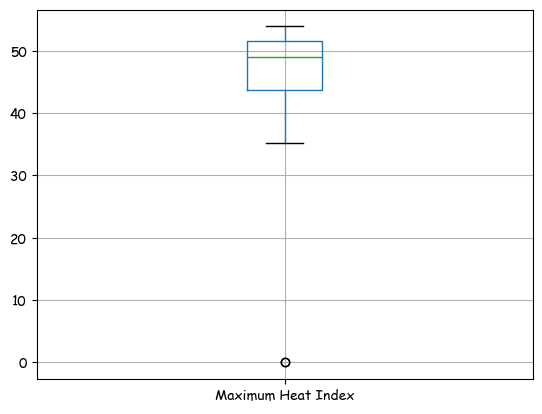

In [297]:
manila_heatindex_tomorrowio.boxplot('Maximum Heat Index')


In [299]:
phl_cities_heatindex_pasay_max

,Year,Month,Day,Maximum Heat Index,time,lat,lon,geometry,city
0,2023,3,1,33,1/3/2023,14.5884,120.9679,POINT (120.96790 14.58840),Manila Port
1,2023,3,2,32,2/3/2023,14.5884,120.9679,POINT (120.96790 14.58840),Manila Port
2,2023,3,3,32,3/3/2023,14.5884,120.9679,POINT (120.96790 14.58840),Manila Port
3,2023,3,4,31,4/3/2023,14.5884,120.9679,POINT (120.96790 14.58840),Manila Port
4,2023,3,5,31,5/3/2023,14.5884,120.9679,POINT (120.96790 14.58840),Manila Port
...,...,...,...,...,...,...,...,...,...
117,2023,6,26,39,2023-06-26 00:00:00,14.5047,121.0167,POINT (121.01670 14.50470),Pasay
118,2023,6,27,39,2023-06-27 00:00:00,14.5047,121.0167,POINT (121.01670 14.50470),Pasay
119,2023,6,28,42,2023-06-28 00:00:00,14.5047,121.0167,POINT (121.01670 14.50470),Pasay
120,2023,6,29,38,2023-06-29 00:00:00,14.5047,121.0167,POINT (121.01670 14.50470),Pasay


In [343]:
output_notebook()
show(get_line_plot(pd.concat([manila_heatindex_tomorrowio, phl_cities_heatindex_pasay_max]), measure = 'Maximum Heat Index', title = 'Average Heat Index', subtitle = 'heat index calculated from Tomorrow.io', source= 'Tomorrow.io'))

Loading BokehJS ...

c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [242]:
output_notebook()
show(get_line_plot(phl_cities_heatindex_pasay, measure = 'Average Heat Index', title = 'Average Heat Index', subtitle = 'heat index calculated from NWS(2011)', source= 'PASAY, Govt of Philippines'))

Loading BokehJS ...

In [121]:
output_notebook()
show(get_line_plot(phl_cities_hwdi_mean2, measure = 'heat_waves_per_time_period', title = 'Heatwaves per time period', subtitle = 'heatwave is defined as 2 consecutive days where the mean temperature is more than 5 degrees of the mean temperature of the baseline from 1948 to 2014', source= 'GLDAS data with analysis from the Data Lab, World Bank'))

Loading BokehJS ...

In [123]:
output_notebook()
from bokeh.models import Panel
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for value in list(['min', 'max', 'mean']):

    tabs.append(Panel(child=get_line_plot(phl_cities_heatindex_year.reset_index(), f"Heat Index Per Year", "Source: ACLED",measure=value,  subtitle = 'Heat index is calculated using both temperature and relative humidity'), title=value.capitalize()
                ))

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [126]:
output_notebook()
from bokeh.models import Panel
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for value in list(['min', 'max', 'mean']):

    tabs.append(Panel(child=get_line_plot(phl_cities_heatindex_month.reset_index(), f"Heat Index Per Year", "Source: ACLED",measure=value,  subtitle = 'Heat index is calculated using both temperature and relative humidity'), title=value.capitalize()
                ))

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [112]:
output_notebook()
phl_cities_heatindex_month.reset_index(inplace=True)
show(get_line_plot(phl_cities_heatindex_month, measure = 'max', title = 'Max Heat Index Per Month', subtitle = 'Heat index is calculated using both temperature and relative humidity', source= 'GLDAS data with analysis from the Data Lab, World Bank'))

Loading BokehJS ...